# An RNN model to generate sequences
Multi-site model

In [51]:
import math
import numpy as np
from matplotlib import pyplot as plt
import utils_prettystyle
import utils_batching
import tensorflow as tf
print("Tensorflow version: " + tf.__version__)

Tensorflow version: 1.6.0


## Load temperatures

In [52]:
#32 weather stations
weather_stations = ['USC00010655.csv','USC00012813.csv','USC00016478.csv','USC00020949.csv','USC00021314.csv',
'USC00025270.csv','USC00025635.csv','USC00026468.csv','USC00029359.csv','USC00030458.csv','USC00031152.csv',
'USC00031948.csv','USC00032794.csv','USC00032930.csv','USC00033466.csv','USC00033821.csv','USC00033862.csv',
'USC00036920.csv','USC00036928.csv','USC00040343.csv','USC00041244.csv','USC00041428.csv','USC00042012.csv',
'USC00042598.csv','USC00042713.csv','USC00042934.csv','USC00043261.csv','USC00043551.csv','USC00043875.csv',
'USC00044957.csv']

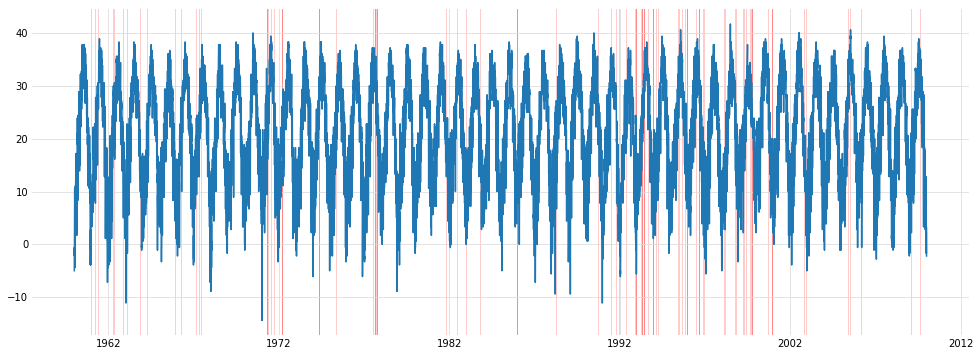

18262


In [158]:
temperatures = np.genfromtxt(open("temperatures/"+weather_stations[7], "rb"), delimiter=",", skip_header=True,
                      usecols=[0,1,2,3], converters = {0: lambda s: np.datetime64(s)})

# You can adjust the visualisation range here
# Interpolated regions of the dataset are marked in red
visu_temperatures = temperatures[:]

# when reading from CSV, numpy names its columns f0, f1, f2, ...
dates = visu_temperatures[:]['f0']
min_temps = visu_temperatures[:]['f1']
max_temps = visu_temperatures[:]['f2']
interpolated = visu_temperatures[:]['f3']

interpolated_sequence = False
plt.plot(dates, max_temps)
for i, date in enumerate(dates):
    if interpolated[i]:
        if not interpolated_sequence:
            startdate = date
        interpolated_sequence = True
        stopdate=date
    else:
        if interpolated_sequence:
            # light shade of red just for visibility
            plt.axvspan(startdate+np.timedelta64(-5, 'D'), stopdate+np.timedelta64(6, 'D'), facecolor='#FFCCCC', alpha=1)
            # actual interpolated region
            plt.axvspan(startdate+np.timedelta64(-1, 'D'), stopdate+np.timedelta64(1, 'D'), facecolor='#FF8888', alpha=1)
        interpolated_sequence = False
plt.show()

# the dataset we will be working with
traindata = temperatures[:]['f2'] # max temperatures

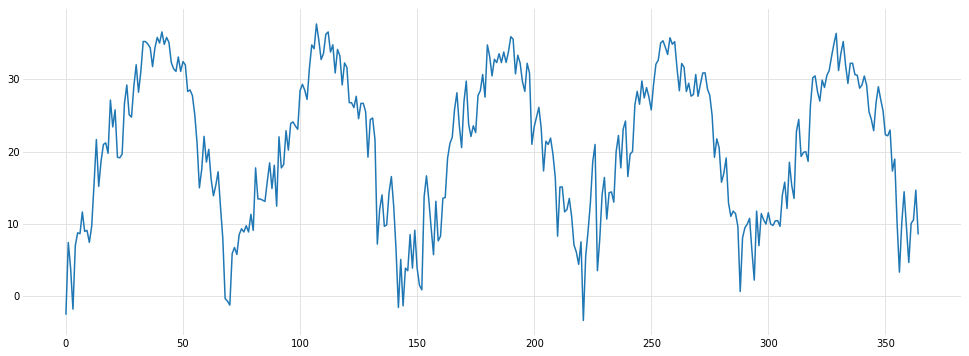

3652


In [185]:
RESAMPLE_BY = 5
DATA_SEQ_LEN = traindata.shape[0]//RESAMPLE_BY*RESAMPLE_BY
data = np.reshape(traindata[:DATA_SEQ_LEN], [-1, RESAMPLE_BY])
data = np.mean(data, axis=1)
plt.plot(data[:365*5//RESAMPLE_BY]) # display five years worth of data
plt.show()
DATA_SEQ_LEN = DATA_SEQ_LEN // RESAMPLE_BY
print(DATA_SEQ_LEN)

## Hyperparameters

In [188]:
RNN_CELLSIZE = 100  # size of the RNN cells
NLAYERS = 2         # number of stacked RNN cells (needed for tensor shapes but code must be changed manually)
SEQLEN = 64         # unrolled sequence length
BATCHSIZE = 16      # mini-batch size
DROPOUT_PKEEP = 0.7 # probability of neurons not being dropped (should be between 0.5 and 1)
ACTIVATION = tf.nn.tanh # Activation function for GRU cells (tf.nn.relu or tf.nn.tanh)

## Visualize training sequences
This is what the neural network will see during training.

Sample shape: (16, 64)
Label shape: (16, 64)
Excerpt from first batch:


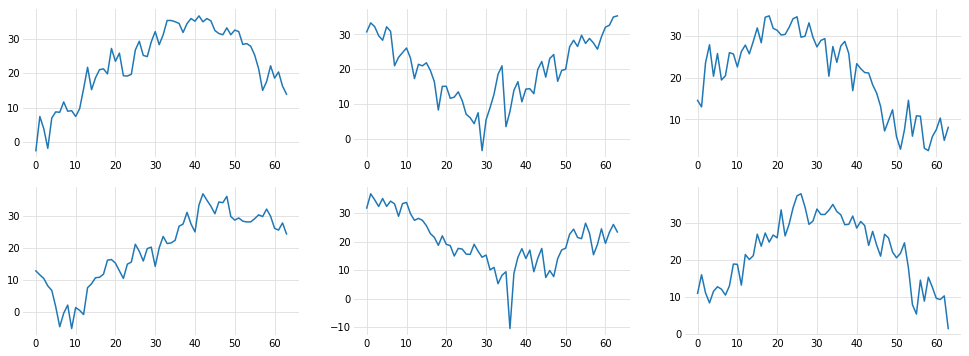

In [189]:
# The function dumb_minibatch_sequencer splits the data into batches of sequences sequentially.
for samples, labels, epoch in utils_batching.rnn_minibatch_sequencer(data, BATCHSIZE, SEQLEN, nb_epochs=1):
    break
print("Sample shape: " + str(samples.shape))
print("Label shape: " + str(labels.shape))
print("Excerpt from first batch:")
subplot = 231
for i in range(6):
    plt.subplot(subplot)
    plt.plot(samples[i])
    subplot += 1
plt.show()

## The model definition
When executed, this function instantiates the Tensorflow graph for our model.
![deep RNN schematic](images/deep_rnn.png)

In [190]:
def model_rnn_fn(features, Hin, labels, dropout_pkeep):
    X = features
    batchsize = tf.shape(X)[0]
    seqlen = tf.shape(X)[1]
    
    cells = [tf.nn.rnn_cell.GRUCell(RNN_CELLSIZE, activation=ACTIVATION) for _ in range(NLAYERS)]
    # dropout useful between cell layers only: no output dropout on last cell
    dcells = [tf.nn.rnn_cell.DropoutWrapper(cell, output_keep_prob = dropout_pkeep) for cell in cells[:-1]]
    dcells.append(cells[-1])
    # a stacked RNN cell still works like an RNN cell
    cell = tf.nn.rnn_cell.MultiRNNCell(dcells, state_is_tuple=False)
    # X[BATCHSIZE, SEQLEN, 1], Hin[BATCHSIZE, RNN_CELLSIZE*NLAYERS]
    # the sequence unrolling happens here
    Yn, H = tf.nn.dynamic_rnn(cell, X, initial_state=Hin, dtype=tf.float32)
    # Yn[BATCHSIZE, SEQLEN, RNN_CELLSIZE]
    Yn = tf.reshape(Yn, [batchsize*seqlen, RNN_CELLSIZE])
    Yr = tf.layers.dense(Yn, 1) # Yr [BATCHSIZE*SEQLEN, 1]
    Yr = tf.reshape(Yr, [batchsize, seqlen, 1]) # Yr [BATCHSIZE, SEQLEN, 1]
    Yout = Yr[:,-1,:] # Last output Yout [BATCHSIZE, 1]
    
    loss = tf.losses.mean_squared_error(Yr, labels) # labels[BATCHSIZE, SEQLEN, 1]
    optimizer = tf.train.AdamOptimizer(learning_rate=0.01)
    train_op = optimizer.minimize(loss)
    
    return Yout, H, loss, train_op, Yr

## Instantiate the model

In [191]:
# placeholder for inputs
Hin = tf.placeholder(tf.float32, [None, RNN_CELLSIZE * NLAYERS])
samples = tf.placeholder(tf.float32, [None, None, 1]) # [BATCHSIZE, SEQLEN, 1]
labels = tf.placeholder(tf.float32, [None, None, 1]) # [BATCHSIZE, SEQLEN, 1]
dropout_pkeep = tf.placeholder(tf.float32)

# instantiate the model
Yout, H, loss, train_op, Yr = model_rnn_fn(samples, Hin, labels, dropout_pkeep)

## Inference
This is a generative model: run one trained RNN cell in a loop

In [192]:
def prediction_run(prime_data, run_length):
    H_ = np.zeros([1, RNN_CELLSIZE * NLAYERS]) # zero state initially
    Yout_ = np.zeros([1, 1])
    data_len = prime_data.shape[0]

    # prime the state from data
    if data_len > 0:
        Yin = np.array(prime_data)
        Yin = np.reshape(Yin, [1, data_len, 1]) # reshape as one sequence
        feed = {Hin: H_, samples: Yin, dropout_pkeep: 1.0} # no dropout during inference
        Yout_, H_ = sess.run([Yout, H], feed_dict=feed)
    
    # run prediction
    # To generate a sequence, run a trained cell in a loop passing as input and input state
    # respectively the output and output state from the previous iteration.
    results = []
    for i in range(run_length):
        Yout_ = np.reshape(Yout_, [1, 1, 1]) # batch of a single sequence of a single vector with one element
        feed = {Hin: H_, samples: Yout_, dropout_pkeep: 1.0} # no dropout during inference
        Yout_, H_ = sess.run([Yout, H], feed_dict=feed)
        results.append(Yout_[0,0])
        
    return np.array(results)

## Initialize Tensorflow session
This resets all neuron weights and biases to initial random values

In [193]:
# first input state
Hzero = np.zeros([BATCHSIZE, RNN_CELLSIZE * NLAYERS])
# variable initialization
sess = tf.Session()
init = tf.global_variables_initializer()
sess.run([init])

[None]

## The training loop
You can re-execute this cell to continue training

epoch 0, batch 0, loss=576.3818


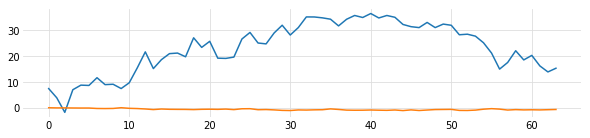

epoch 10, batch 30, loss=92.53827
epoch 20, batch 60, loss=18.436235
epoch 30, batch 90, loss=11.792118


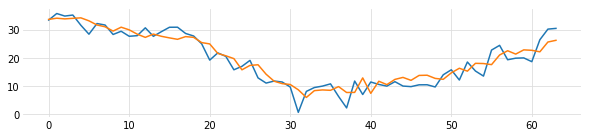

epoch 40, batch 120, loss=11.515677
epoch 50, batch 150, loss=11.471191
epoch 60, batch 180, loss=10.74744


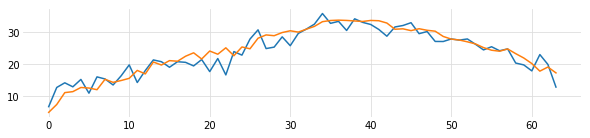

epoch 70, batch 210, loss=10.776306
epoch 80, batch 240, loss=10.322172
epoch 90, batch 270, loss=10.053455
epoch 100, batch 300, loss=10.806896


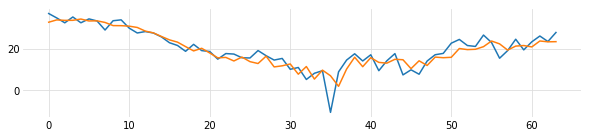

epoch 110, batch 330, loss=9.736322
epoch 120, batch 360, loss=9.924843
epoch 130, batch 390, loss=10.128974


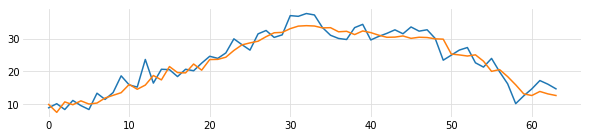

epoch 140, batch 420, loss=9.121929
epoch 150, batch 450, loss=9.270588
epoch 160, batch 480, loss=8.812155


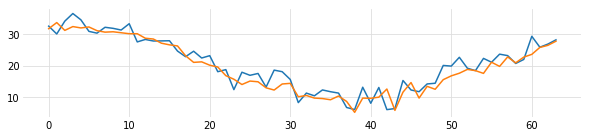

epoch 170, batch 510, loss=8.497513
epoch 180, batch 540, loss=8.109481
epoch 190, batch 570, loss=7.668477
epoch 200, batch 600, loss=8.501647


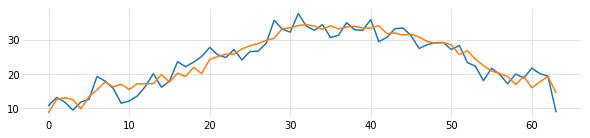

epoch 210, batch 630, loss=7.943536
epoch 220, batch 660, loss=6.948265
epoch 230, batch 690, loss=6.8486323


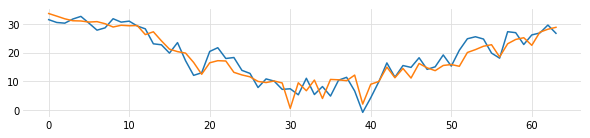

epoch 240, batch 720, loss=7.1658783
epoch 250, batch 750, loss=7.549517
epoch 260, batch 780, loss=8.249497


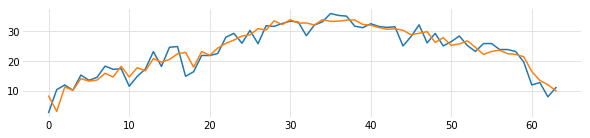

epoch 270, batch 810, loss=6.994215
epoch 280, batch 840, loss=6.5472846
epoch 290, batch 870, loss=6.284133
epoch 300, batch 900, loss=6.6377935


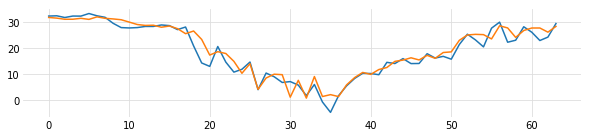

epoch 310, batch 930, loss=6.4008856
epoch 320, batch 960, loss=5.642085
epoch 330, batch 990, loss=5.150341


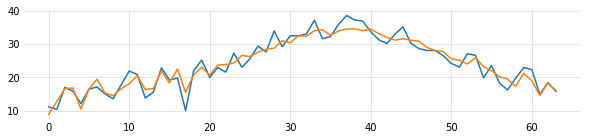

epoch 340, batch 1020, loss=4.9406757
epoch 350, batch 1050, loss=4.662258
epoch 360, batch 1080, loss=4.3321133


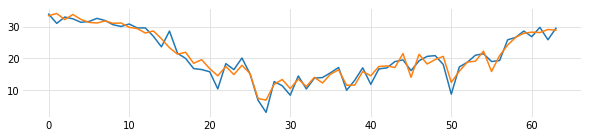

epoch 370, batch 1110, loss=4.8740263
epoch 380, batch 1140, loss=7.3620787
epoch 390, batch 1170, loss=7.1419983
epoch 400, batch 1200, loss=5.536275


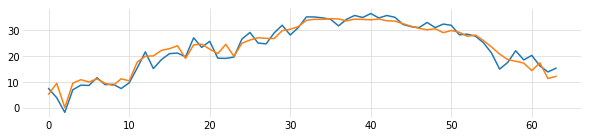

epoch 410, batch 1230, loss=6.8785467
epoch 420, batch 1260, loss=6.674302
epoch 430, batch 1290, loss=6.517517


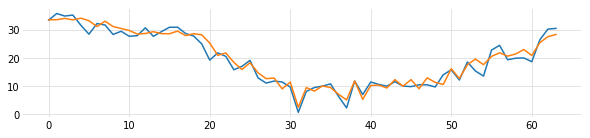

epoch 440, batch 1320, loss=5.7790422
epoch 450, batch 1350, loss=4.6698375
epoch 460, batch 1380, loss=3.8815646


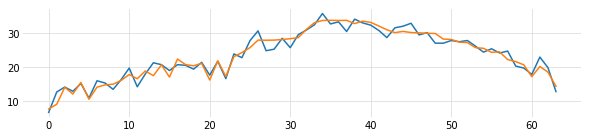

epoch 470, batch 1410, loss=3.9975226
epoch 480, batch 1440, loss=3.9389658
epoch 490, batch 1470, loss=3.5162916


In [194]:
NB_EPOCHS = 500

H_ = Hzero
losses = []
indices = []
for i, (next_samples, next_labels, epoch) in enumerate(utils_batching.rnn_minibatch_sequencer(data, BATCHSIZE, SEQLEN, nb_epochs=NB_EPOCHS)):
    next_samples = np.expand_dims(next_samples, axis=2) # model wants 3D inputs [BATCHSIZE, SEQLEN, 1] 
    next_labels = np.expand_dims(next_labels, axis=2)

    feed = {Hin: H_, samples: next_samples, labels: next_labels, dropout_pkeep: DROPOUT_PKEEP}
    Yout_, H_, loss_, _, Yr_ = sess.run([Yout, H, loss, train_op, Yr], feed_dict=feed)
    # print progress
    if i%30 == 0:
        print("epoch " + str(epoch) + ", batch " + str(i) + ", loss=" + str(np.mean(loss_)))
    if i%10 == 0:
        losses.append(np.mean(loss_))
        indices.append(i)
    if i%100 == 0:
        plt.figure(figsize=(10,2))
        plt.plot(next_labels[0,:,0])
        plt.plot(Yr_[0,:,0])
        plt.show()

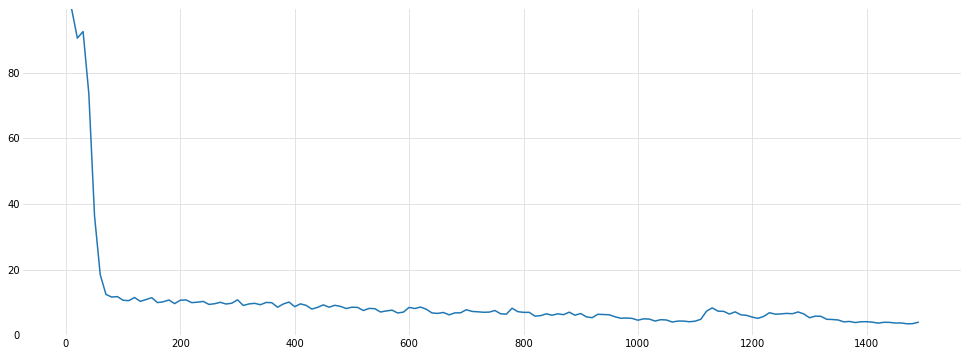

In [195]:
plt.ylim(ymax=np.amax(losses[1:])) # ignore first value for scaling
plt.plot(indices, losses)
plt.show()

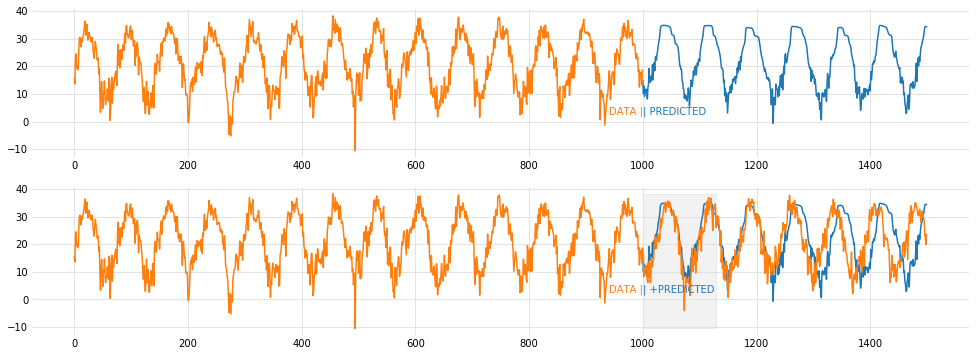

RMSE on 128 predictions (shaded area): 4.640079932743272


In [196]:
PRIMELEN=1000
RUNLEN=500
OFFSET=310

prime_data = data[OFFSET:OFFSET+PRIMELEN]

results = prediction_run(prime_data, RUNLEN)

disp_data = data[OFFSET:OFFSET+PRIMELEN+RUNLEN]
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
plt.subplot(211)
plt.text(PRIMELEN,2.5,"DATA |", color=colors[1], horizontalalignment="right")
plt.text(PRIMELEN,2.5,"| PREDICTED", color=colors[0], horizontalalignment="left")
displayresults = np.ma.array(np.concatenate((np.zeros([PRIMELEN]), results)))
displayresults = np.ma.masked_where(displayresults == 0, displayresults)
plt.plot(displayresults)
displaydata = np.ma.array(np.concatenate((prime_data, np.zeros([RUNLEN]))))
displaydata = np.ma.masked_where(displaydata == 0, displaydata)
plt.plot(displaydata)
plt.subplot(212)
plt.text(PRIMELEN,2.5,"DATA |", color=colors[1], horizontalalignment="right")
plt.text(PRIMELEN,2.5,"| +PREDICTED", color=colors[0], horizontalalignment="left")
plt.plot(displayresults)
plt.plot(disp_data)
RMSELEN=128
plt.axvspan(PRIMELEN, PRIMELEN+RMSELEN, color='grey', alpha=0.1, ymin=0.05, ymax=0.95)
plt.show()

rmse = math.sqrt(np.mean((data[OFFSET+PRIMELEN:OFFSET+PRIMELEN+RMSELEN] - results[:RMSELEN])**2))
print("RMSE on {} predictions (shaded area): {}".format(RMSELEN, rmse))

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at
[http://www.apache.org/licenses/LICENSE-2.0](http://www.apache.org/licenses/LICENSE-2.0)
Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.